# Comparing Regionally Split and Global Scenarios

In [1]:
# NBVAL_IGNORE_OUTPUT
import pandas as pd

import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData
from pymagicc.scenarios import rcp26, rcp45, rcp60, rcp85

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 16, 9

# Regional Split

MAGICC focusses on global-mean outputs, but internally it runs in four boxes: northern hemisphere ocean, southern hemisphere ocean, northern hemisphere land and southern hemisphere land. 
As the user, emissions can be passed to MAGICC with different levels of regional detail.
In particular, emissions can either be passed at the global level, or they can be passed with greater regional detail (the most detailed of which is the R5 regions: R5ASIA, R5LAM, R5REF, R5MAF, R5OECD and BUNKERS, see [here](https://tntcat.iiasa.ac.at/AR5DB/dsd?Action=htmlpage&page=about#regiondefs)). 
In both cases, MAGICC will internally map the provided emissions into its own internal four boxes. 

In this notebook we investigate the impact of providing emissions at the global level compared to running with a more detailed regional split.
In effect, we are examining how much the regional distribution of emissions impacts global-mean temperature outputs in MAGICC. 
For this, we use the RCP `.SCEN` files which ship with MAGICC6.

The following shows that for the RCPs there are no large differences (<= 0.01 degrees for the global surface temperature).

In [3]:
# NBVAL_IGNORE_OUTPUT
pymagicc.__version__

'2.0.0rc4+40.g3d3e7ff.dirty'

In [4]:
runs = {
    "Regionally Split Scenario": {},
    "Global Scenario": {},
}

for rcp in [rcp26, rcp45, rcp60, rcp85]:
    # for rcp in [rcp26]:
    rcp_name = rcp.meta.scenario.iloc[0]
    print(rcp_name)
    results = pymagicc.run(rcp, out_emissions=1)

    temp = results.filter(
        variable="Surface Temperature", region="World*", year=range(1990, 2101)
    )

    ts = temp.timeseries()

    rcp_world = rcp.copy().filter(region="World")

    results_world = pymagicc.run(rcp_world, out_emissions=1)

    temp = results_world.filter(
        variable="Surface Temperature", region="World*", year=range(1990, 2101)
    )

    ts_world = temp.timeseries()

    runs["Regionally Split Scenario"][rcp_name] = results
    runs["Global Scenario"][rcp_name] = results_world

RCP26
RCP45
RCP60
RCP85


model  scenario  region                           variable             unit  climate_model  todo        
IMAGE  RCP26     World                            Surface Temperature  K     MAGICC6        not_relevant    0.010562
                 World|Northern Hemisphere|Land   Surface Temperature  K     MAGICC6        not_relevant    0.022406
                 World|Northern Hemisphere|Ocean  Surface Temperature  K     MAGICC6        not_relevant    0.016199
                 World|Southern Hemisphere|Land   Surface Temperature  K     MAGICC6        not_relevant    0.006166
                 World|Southern Hemisphere|Ocean  Surface Temperature  K     MAGICC6        not_relevant    0.002733
dtype: float64
model    scenario  region                           variable             unit  climate_model  todo        
MiniCAM  RCP45     World                            Surface Temperature  K     MAGICC6        not_relevant    0.008971
                   World|Northern Hemisphere|Land   Surface Temperatu

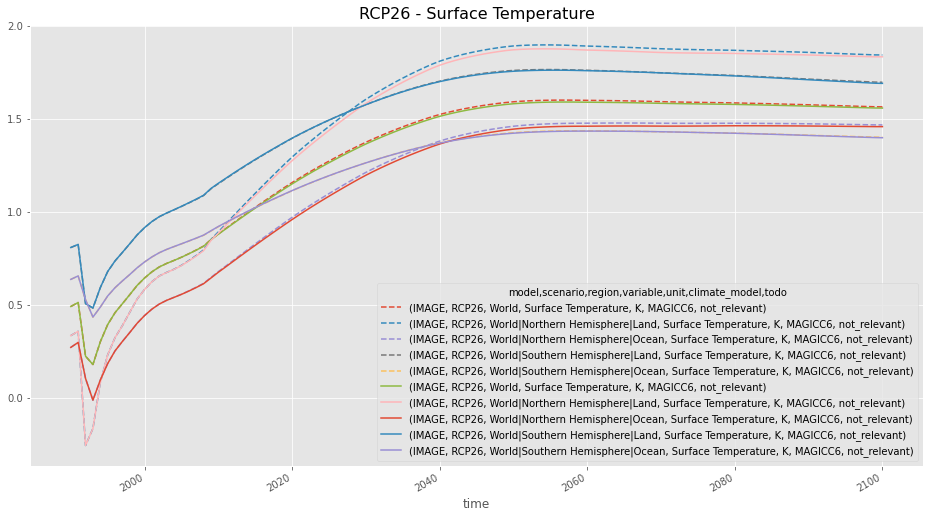

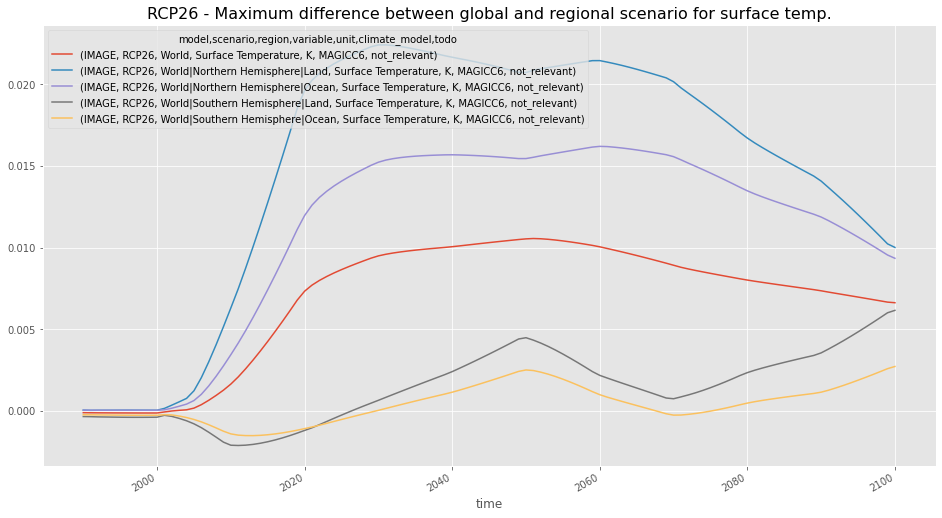

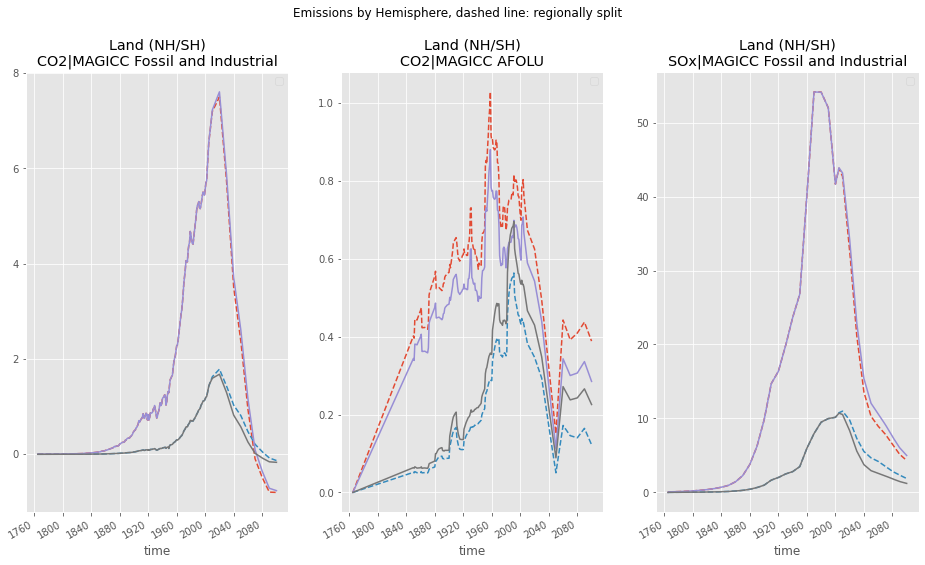

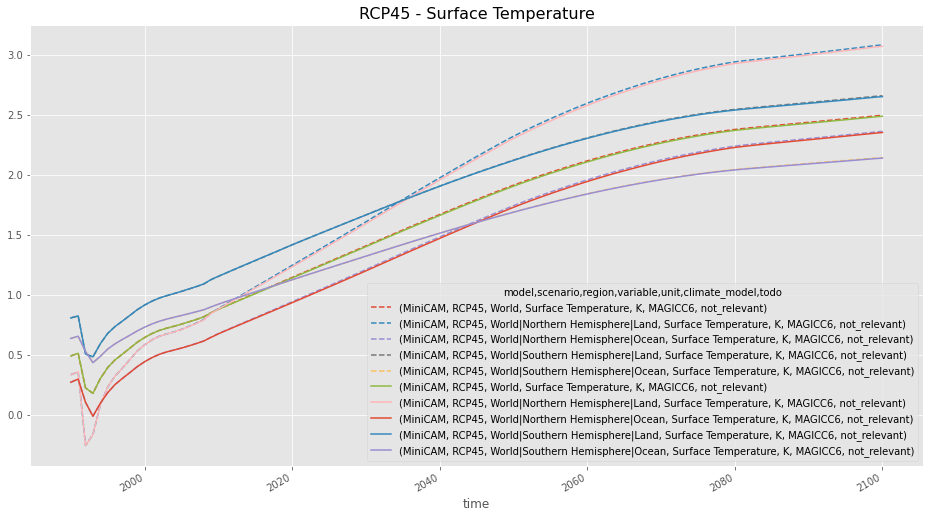

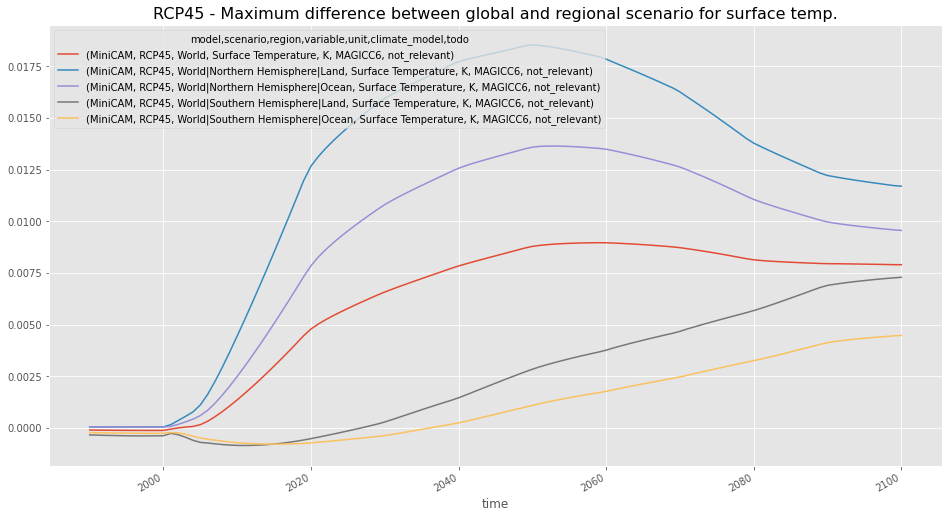

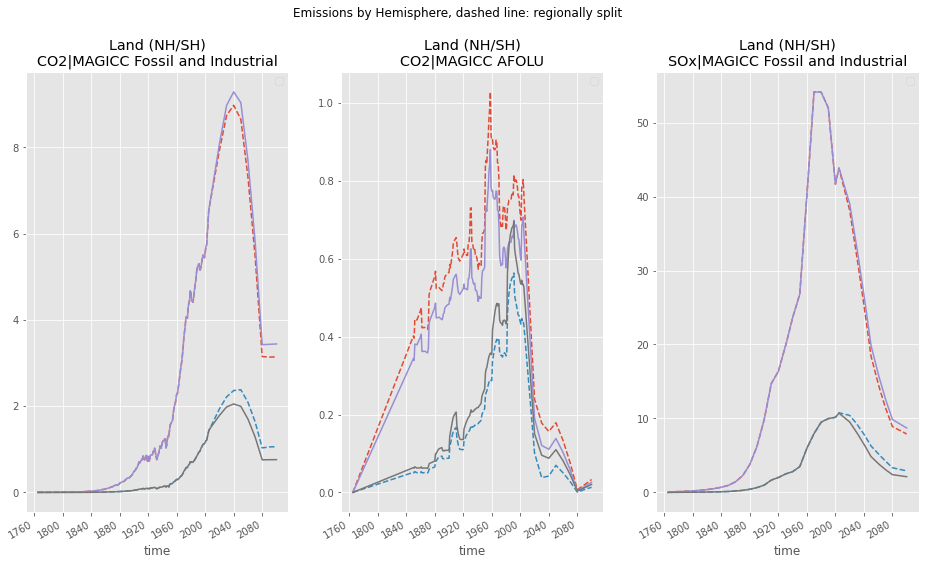

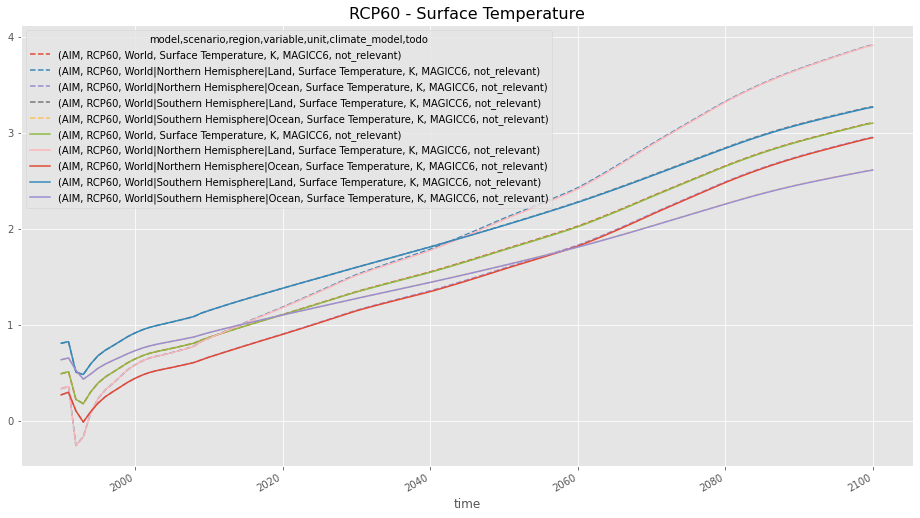

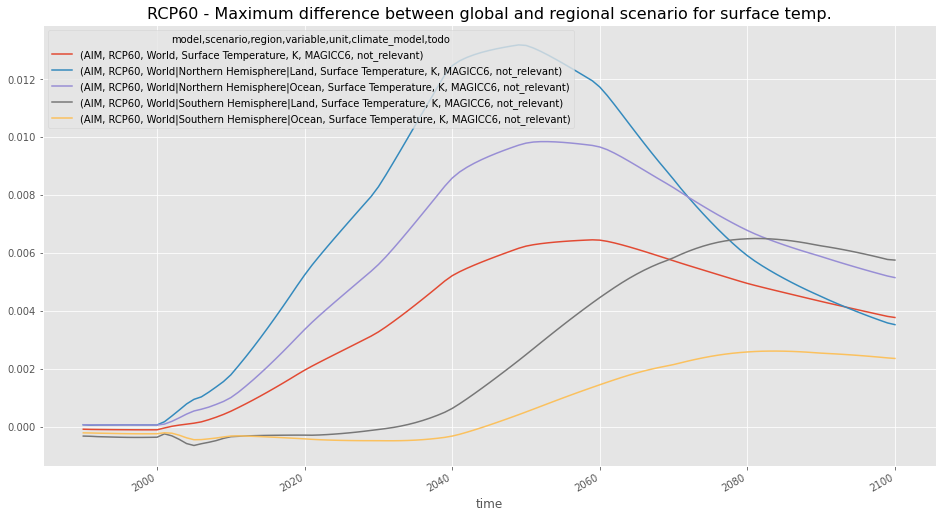

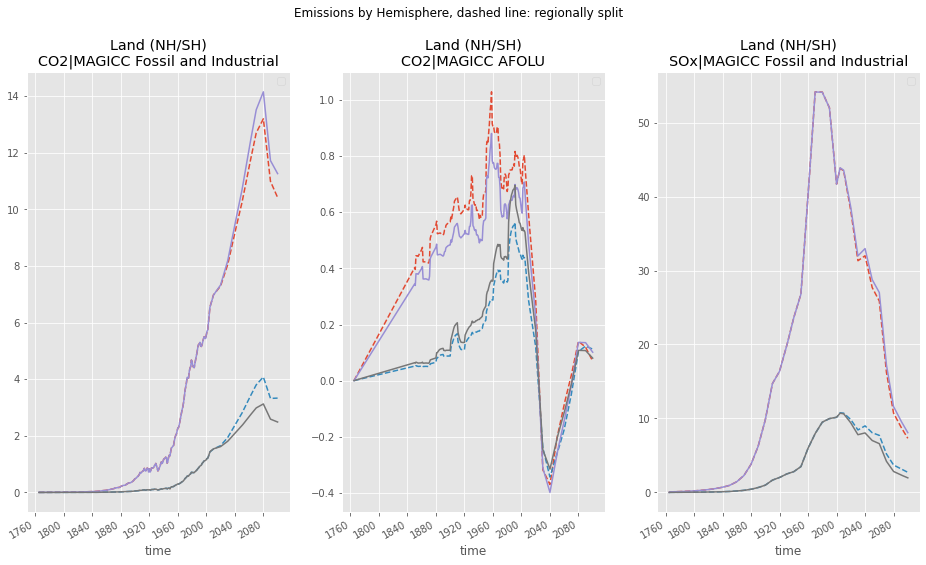

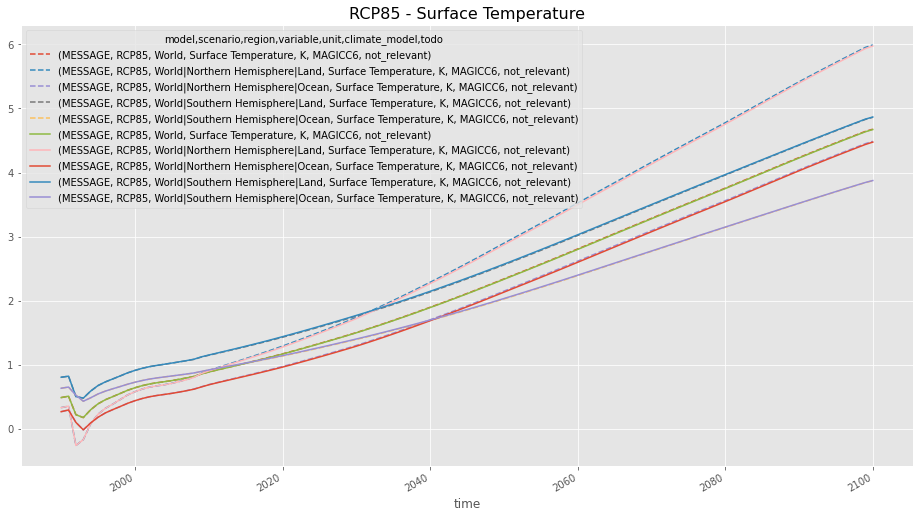

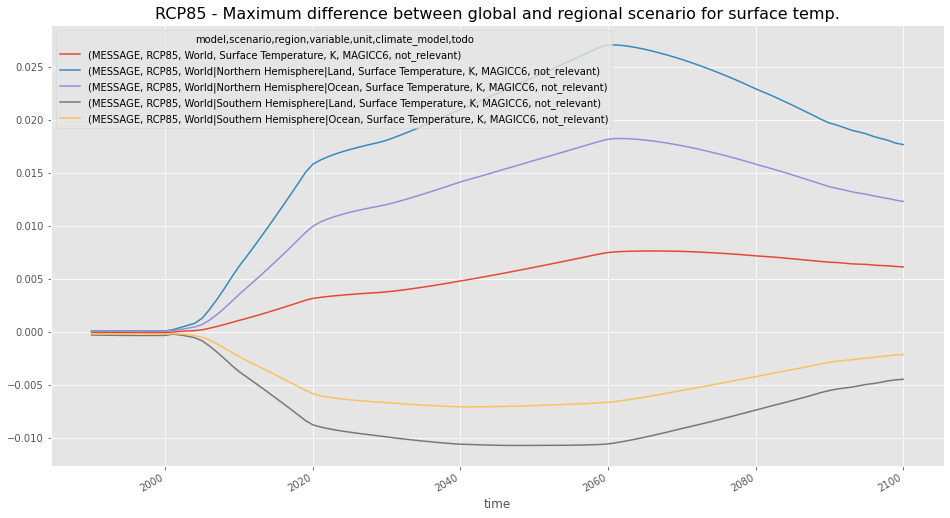

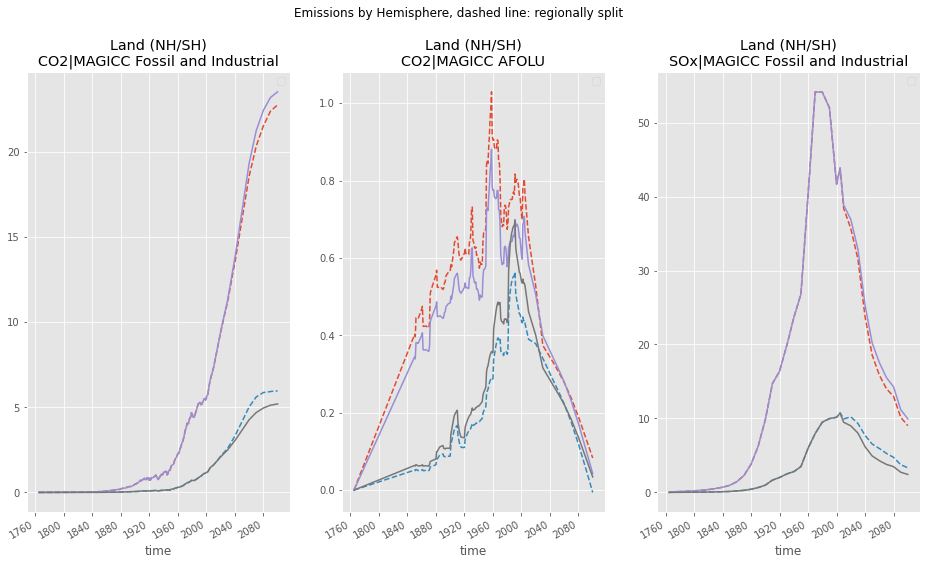

In [5]:
# NBVAL_IGNORE_OUTPUT
for rcp_name in runs["Global Scenario"].keys():

    results = runs["Regionally Split Scenario"][rcp_name]

    temp = results.filter(
        variable="Surface Temperature", region="World*", year=range(1990, 2101)
    )
    ts = temp.timeseries()

    results_world = runs["Global Scenario"][rcp_name]
    temp = results_world.filter(
        variable="Surface Temperature", region="World*", year=range(1990, 2101)
    )
    ts_world = temp.timeseries()

    _, ax = plt.subplots()
    ts.T.plot(style="--", ax=ax)
    ts_world.T.plot(ax=ax)
    ax.set_title(rcp_name + " - Surface Temperature", fontsize=16)

    _, ax = plt.subplots()
    (ts.T - ts_world.T).plot(ax=ax)
    ax.set_title(
        rcp_name
        + " - Maximum difference between global and regional scenario for surface temp.",
        fontsize=16,
    )

    print((ts_world - ts).T.abs().max())

    fig, ax = plt.subplots(1, 3)
    fig.suptitle("Emissions by Hemisphere, dashed line: regionally split")
    region = "*Land*"
    for idx, var in enumerate(
        [
            "Emissions|CO2|MAGICC Fossil and Industrial",
            "Emissions|CO2|MAGICC AFOLU",
            "Emissions|SOx|MAGICC Fossil and Industrial",
        ]
    ):

        results.filter(variable=var, region=region).timeseries().T.plot(
            style="--", ax=ax[idx]
        )
        results_world.filter(variable=var, region=region).timeseries().T.plot(
            ax=ax[idx]
        )
        ax[idx].set_title("Land (NH/SH)\n" + var.replace("Emissions|", ""))

        ax[idx].legend("")